In [1]:
from scipy.io import loadmat, whosmat
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json 
import os
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from google.colab import drive

Using TensorFlow backend.


In [2]:
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd '/content/drive/My Drive/Battery'

/content/drive/My Drive/Battery


In [5]:
df_charge = pd.DataFrame()
df_discharge = pd.DataFrame()

load_folder = './Source' 
json_foler = './JSON/'
csv_foler = './CSV/'

used_row = 165

In [6]:
def load_data():
    filenames = [f for f in os.listdir(load_folder) if f.endswith('.mat')]

    df_discharge = pd.DataFrame()
    df_charge = pd.DataFrame()

    for filename in filenames:
        name = filename.split('.mat')[0]
        print(name)
        struct = loadmat(load_folder + '/' + filename)
        mess = struct[name][0][0][0][0]

        discharge, charge, impedance = build_dictionaries(mess)

        df_discharge = df_discharge.append(extract_feature(name, discharge))
        df_charge = df_charge.append(extract_feature(name, charge))

        # -------- mat-->json 저장 -------- #
        # save_json(discharge, json_foler + name + '_discharge')
        # save_json(charge, json_foler + name + '_charge')
        # save_json(impedance, json_foler + name + '_impedance')

    return df_charge, df_discharge

# Build dictionaries from data structures¶

In [7]:
def build_dictionaries(mess):

    discharge, charge, impedance = {}, {}, {}

    for i, element in enumerate(mess):

        step = element[0][0]

        if step == 'discharge':
            discharge[str(i)] = {}
            discharge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            discharge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            discharge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            discharge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            discharge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            discharge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            discharge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            discharge[str(i)]["time"] = data[0][0][5][0].tolist()
            discharge[str(i)]["capacity"] = data[0][0][6][0].tolist()

        if step == 'charge':
            charge[str(i)] = {}
            charge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            charge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            charge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            charge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            charge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            charge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            charge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            charge[str(i)]["time"] = data[0][0][5][0].tolist()        
            charge[str(i)]["capacity"] = []

        if step == 'impedance':
            impedance[str(i)] = {}
            impedance[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            impedance[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            impedance[str(i)]["sense_current"] = {}
            impedance[str(i)]["battery_current"] = {}
            impedance[str(i)]["current_ratio"] = {}
            impedance[str(i)]["battery_impedance"] = {}
            impedance[str(i)]["rectified_impedance"] = {}

            impedance[str(i)]["sense_current"]["real"] = np.real(data[0][0][0][0]).tolist()
            impedance[str(i)]["sense_current"]["imag"] = np.imag(data[0][0][0][0]).tolist()

            impedance[str(i)]["battery_current"]["real"] = np.real(data[0][0][1][0]).tolist()
            impedance[str(i)]["battery_current"]["imag"] = np.imag(data[0][0][1][0]).tolist()

            impedance[str(i)]["current_ratio"]["real"] = np.real(data[0][0][2][0]).tolist()
            impedance[str(i)]["current_ratio"]["imag"] = np.imag(data[0][0][2][0]).tolist()

            impedance[str(i)]["battery_impedance"]["real"] = np.real(data[0][0][3]).tolist()
            impedance[str(i)]["battery_impedance"]["imag"] = np.imag(data[0][0][3]).tolist()

            impedance[str(i)]["rectified_impedance"]["real"] = np.real(data[0][0][4]).tolist()
            impedance[str(i)]["rectified_impedance"]["imag"] = np.imag(data[0][0][4]).tolist()

            impedance[str(i)]["re"] = float(data[0][0][5][0][0])
            impedance[str(i)]["rct"] = float(data[0][0][6][0][0])

    return discharge, charge, impedance

In [8]:
def save_json(dictionary, name):
    with open(name + '.json', 'w') as f:
        json.dump(dictionary, f, indent=4)

In [9]:
def save_csv(df, name):
  df.to_csv(csv_foler + name + ".csv", mode='w')

In [10]:
def extract_feature(filename, target):
  df = pd.DataFrame()

  for key in target.keys():
    df_cycle = pd.DataFrame()
    df_cycle['voltage_battery'] = target[key]['voltage_battery']
    df_cycle['current_battery'] = target[key]['current_battery']
    df_cycle['temp_battery'] = target[key]['temp_battery']
    df_cycle['current_load'] = target[key]['current_load']
    df_cycle['voltage_load'] = target[key]['voltage_load']
    df_cycle['time'] = target[key]['time']  
    df_cycle['capacity'] = pd.Series(target[key]['capacity'])    
    #df_cycle['capacity'] = df_cycle['capacity'].max()
    df_cycle['cycle'] = key 
    df_cycle['battery'] = filename

    df = df.append(df_cycle)

  return df

In [11]:
def update_rn(df):
  idx = 1

  for cy in df['cycle'].unique() :
    df.loc[df['cycle'] == cy, 'rn'] = str(idx)
    idx += 1
    
  return df

In [12]:
def extract_charge_process_to_dataframe(df):

  feature_length = 10
  mod_val = len(df)%feature_length + 1 
  df_tmp = df.loc[:len(df)-mod_val, :]

  #-----------voltage-----------#
  voltage = df_tmp['voltage_battery'].values
  voltage = voltage.reshape(-1,10) # 행이 10개인 배열로 변경
  #voltage.shape

  voltage_mean = pd.DataFrame(voltage, columns=list('0123456789')).mean().values #열 기준 평균
  voltage_mean = voltage_mean.reshape(-1,10)
  df_voltage = pd.DataFrame(voltage_mean)  

  #-----------current-----------#
  current = df_tmp['current_battery'].values
  current = current.reshape(-1,10) # 행이 10개인 배열로 변경
  #current.shape

  current_mean = pd.DataFrame(current, columns=list('0123456789')).mean().values #열 기준 평균
  current_mean = current_mean.reshape(-1,10)
  df_current = pd.DataFrame(current_mean)  

  #-----------temperature-----------#
  temperature = df_tmp['temp_battery'].values
  temperature = temperature.reshape(-1,10) # 행이 10개인 배열로 변경
  #current.shape

  temperature_mean = pd.DataFrame(temperature, columns=list('0123456789')).mean().values #열 기준 평균
  temperature_mean = temperature_mean.reshape(-1,10)
  df_temperature = pd.DataFrame(temperature_mean)  


  return df_voltage, df_current, df_temperature

In [13]:
def extract_charge_process_to_array(df):
    feature_length = 10
    mod_val = len(df)%feature_length + 1 
    df_tmp = df.loc[:len(df)-mod_val, :]
    
    #-----------voltage-----------#
    voltage = df_tmp['voltage_battery'].values
    voltage = voltage.reshape(-1,10) # 행이 10개인 배열로 변경
    #voltage.shape
    voltage_mean = pd.DataFrame(voltage, columns=list('0123456789')).mean().values #열 기준 평균
    voltage_mean = voltage_mean.reshape(-1,10)
    
    #-----------current-----------#
    current = df_tmp['current_battery'].values
    current = current.reshape(-1,10) # 행이 10개인 배열로 변경
    #current.shape
    current_mean = pd.DataFrame(current, columns=list('0123456789')).mean().values #열 기준 평균
    current_mean = current_mean.reshape(-1,10)
    
    #-----------temperature-----------#
    temperature = df_tmp['temp_battery'].values
    temperature = temperature.reshape(-1,10) # 행이 10개인 배열로 변경
    #current.shape
    temperature_mean = pd.DataFrame(temperature, columns=list('0123456789')).mean().values #열 기준 평균
    temperature_mean = temperature_mean.reshape(-1,10)
    
    #----- merage array ----# 
    rtn = np.append(voltage_mean, current_mean)
    rtn = np.append(rtn, temperature_mean)
    
    
    #rtn.reshape(-1,10) #3*10 2차원 배열
    
    
    return rtn.reshape(1,-1)

In [14]:
def extract_capacity(df):
    df_drop = df.dropna()
    df_drop['rn'] = 0
    df_cap_b0005 = update_rn(df_drop[df_drop.battery == 'B0005'])
    df_cap_b0006 = update_rn(df_drop[df_drop.battery == 'B0006'])
    df_cap_b0007 = update_rn(df_drop[df_drop.battery == 'B0007'])
    return df_cap_b0005, df_cap_b0006, df_cap_b0007

In [15]:
def plot_capacity(df1, df2, df3):
    plt.figure(figsize=(20,10))
    plt.plot(df1.rn, df1.capacity)
    plt.plot(df2.rn, df2.capacity)
    plt.plot(df3.rn, df3.capacity)
    plt.ylabel('capacity')
    plt.xlabel('cycle')
    plt.title('Battery Capacity')
    plt.show()

# Data Loading

In [16]:
df_charge, df_discharge = load_data()

B0005


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':


B0006
B0007
B0018


# Capacity Loading

In [17]:
df_cap_b0005, df_cap_b0006, df_cap_b0007 = extract_capacity(df_discharge)

df_cap_b0005 = df_cap_b0005[:used_row]
df_cap_b0006 = df_cap_b0006[:used_row]
df_cap_b0007 = df_cap_b0007[:used_row]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
df_cap_b0005.head()

,voltage_battery,current_battery,temp_battery,current_load,voltage_load,time,capacity,cycle,battery,rn
0,4.191492,-0.004902,24.330034,-0.0006,0.0,0.0,1.856487,1,B0005,1
0,4.189773,0.000021,24.697752,-0.0006,0.0,0.0,1.846327,3,B0005,2
0,4.188187,-0.001754,24.734266,-0.0006,0.0,0.0,1.835349,5,B0005,3
0,4.188461,-0.002775,24.654236,-0.0006,0.0,0.0,1.835263,7,B0005,4
0,4.188299,-0.007981,24.524797,-0.0006,0.0,0.0,1.834646,9,B0005,5


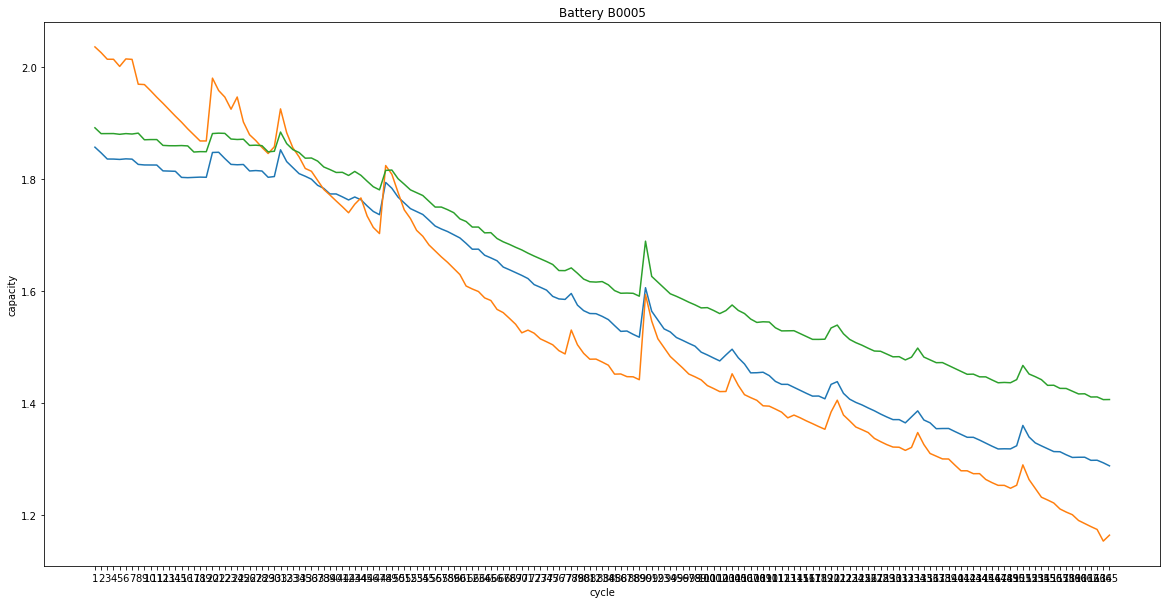

In [19]:
plt.figure(figsize=(20,10))
plt.plot(df_cap_b0005.rn, df_cap_b0005.capacity)
plt.plot(df_cap_b0006.rn, df_cap_b0006.capacity)
plt.plot(df_cap_b0007.rn, df_cap_b0007.capacity)
plt.ylabel('capacity')
plt.xlabel('cycle')
plt.title('Battery B0005')
plt.show()

In [20]:
df_charge[df_charge.battery == 'B0005']['cycle'].unique()

array(['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22',
       '23', '25', '27', '29', '31', '33', '35', '37', '39', '43', '47',
       '51', '55', '59', '63', '67', '71', '75', '79', '83', '84', '87',
       '91', '95', '99', '103', '107', '111', '115', '119', '123', '127',
       '131', '134', '137', '141', '145', '148', '151', '155', '159',
       '163', '167', '171', '175', '179', '183', '187', '191', '195',
       '199', '203', '207', '211', '214', '217', '221', '225', '229',
       '233', '237', '241', '245', '249', '253', '257', '261', '264',
       '267', '271', '275', '279', '283', '287', '291', '295', '299',
       '303', '307', '314', '317', '321', '325', '329', '333', '337',
       '341', '345', '349', '353', '357', '361', '365', '368', '372',
       '376', '380', '384', '388', '392', '396', '400', '404', '408',
       '412', '416', '420', '424', '428', '431', '434', '438', '442',
       '446', '450', '454', '458', '462', '466', '470', '474', '478',
      

In [21]:
df_b005 = df_charge[(df_charge.battery == 'B0005')]

In [22]:
print('B0005 Charge Data : {}'.format(len(df_charge[df_charge.battery == 'B0005']['cycle'].unique())))
print('B0005 Discharge Data : {}'.format(len(df_discharge[df_discharge.battery == 'B0005']['cycle'].unique())))

B0005 Charge Data : 170
B0005 Discharge Data : 168


In [23]:
df_vct = pd.DataFrame()

for cycle in df_b005['cycle'].unique():
    df_cycle = df_b005[df_b005.cycle == cycle]
    vct = extract_charge_process_to_array(df_cycle)
    df_vct = df_vct.append(pd.DataFrame(vct))
        
    
x_data = df_vct[:used_row]    
y_data = df_cap_b0005['capacity']

# MinMaxScaler

In [24]:
scaler = MinMaxScaler()
x_data_scaled = scaler.fit_transform(x_data)
x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data, test_size=0.2, shuffle=True)

x_train_scaled = x_train.reshape(x_train.shape[0],30,1 ) #3차원 텐서 생성
x_test_scaled = x_test.reshape(x_test.shape[0],30,1 )

In [25]:
x = x_data[132:]
x.shape

(33, 30)

In [26]:
'''
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2) 

x_train = x_data[:132]
x_test = x_data[132:]

y_train = y_data[:132]
y_test = y_data[132:]

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0],30,1 ) #3차원 텐서 생성
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0],30,1 )
'''

'\n#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2) \n\nx_train = x_data[:132]\nx_test = x_data[132:]\n\ny_train = y_data[:132]\ny_test = y_data[132:]\n\nscaler = MinMaxScaler()\nx_train_scaled = scaler.fit_transform(x_train)\nx_test_scaled = scaler.transform(x_test)\n\nx_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0],30,1 ) #3차원 텐서 생성\nx_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0],30,1 )\n'

In [27]:
x_train_scaled.shape

(132, 30, 1)

In [36]:
batch_size = 1
hidden_dim = 50

In [37]:
model = Sequential()
model.add(LSTM(hidden_dim, input_shape=(x_train_scaled.shape[1],x_train_scaled.shape[2]))) #timestep, feature)
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['mse']) #평균제곱오차(mean_squared_error-mse). 평균절대오차(mae)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [38]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
history = model.fit(x_train_scaled, y_train, epochs=1000, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stop], validation_data=(x_test_scaled, y_test))

Train on 132 samples, validate on 33 samples
Epoch 1/1000
132/132 [==============================] - 2s 12ms/step - loss: 0.2450 - mse: 0.2450 - val_loss: 0.0415 - val_mse: 0.0415
Epoch 2/1000
132/132 [==============================] - 1s 10ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 3/1000
132/132 [==============================] - 1s 10ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 4/1000
132/132 [==============================] - 1s 11ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 5/1000
132/132 [==============================] - 1s 10ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 6/1000
132/132 [==============================] - 1s 9ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 7/1000
132/132 [==============================] - 1s 10ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 00007

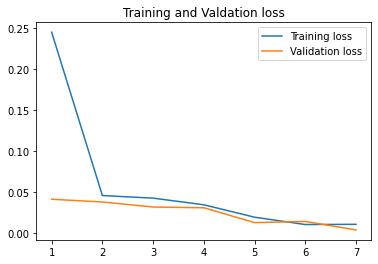

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show() 

In [40]:
score = model.evaluate(x_test_scaled, y_test, batch_size=batch_size)

33/33 [==============================] - 0s 2ms/step


In [41]:
y_hat = model.predict(x_test_scaled)
y_hat

array([[1.8534026],
       [1.5185406],
       [1.3554798],
       [1.7490244],
       [1.4326737],
       [1.7061908],
       [1.4469334],
       [1.7067289],
       [1.803786 ],
       [1.3722484],
       [1.5341442],
       [1.3788012],
       [1.5833082],
       [1.513226 ],
       [1.3752303],
       [1.3809766],
       [1.3862724],
       [1.3669231],
       [1.3284743],
       [1.6352848],
       [1.7384281],
       [1.7080421],
       [1.50955  ],
       [1.3723034],
       [1.4467264],
       [1.3713754],
       [1.6003832],
       [1.3887458],
       [1.5639915],
       [1.3664045],
       [1.6735156],
       [1.4214118],
       [1.3653015]], dtype=float32)

In [42]:
y_test.values, y_hat

list  = [y_test.values, y_hat.reshape(1,-1)]
ds = pd.DataFrame()
ds['y_test'] = y_test.values
ds['y_hat'] = y_hat
ds.shape

(33, 2)

In [43]:
ds

,y_test,y_hat
0,1.804077,1.853403
1,1.548874,1.518541
2,1.422920,1.355480
3,1.773038,1.749024
4,1.563849,1.432674
5,1.804610,1.706191
6,1.506564,1.446933
7,1.773034,1.706729
8,1.830704,1.803786
9,1.323872,1.372248
